Load functions from python files

In [1]:
from load_mol2_data import *
from signature_feature import *
import numpy as np

# Import data from Mol2 file

In [2]:
dir = "mol2 structures/"
import os

dirlist = os.listdir(dir)# list of molecule files
file_dir=dir + dirlist[0]# load the first molecule in the directory
mol=load_atom(file_dir)
adjacent_matrix=load_adjacent_matrix(file_dir)

mol is a list of dictionary contains molecule information: atom types, atom coordinates and atom index. e.g mol[0].ntype outputs the atom types of first atom in the molecule.

In [3]:
print(mol[0].ntype,mol[0].features,mol[0].idx)

C [20.398 -6.29  24.85 ] 1


adjacent_matrix is contains the bond information from the mol2 file, 1 at (i,j) and (j,i) if ith atom is bonded with jth atom.   

In [4]:
print(adjacent_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Compute all the paths originate from an atom in the molecule

We use get_paths function to compute all the paths originate from a given atom.

E.g compute all the paths originated from the 10th atom with the radius of 3 bonds. Output are index array with describe the routes from 10th atom. 

In [5]:
node_index = 10
L = 3
paths = get_paths(node_index, adjacent_matrix, L)
print(paths)

[array([10,  6,  1,  2]), array([10,  6,  1, 47]), array([10,  6,  5,  4]), array([10,  6,  5,  9]), array([10, 11, 12, 16]), array([10, 11, 12, 46]), array([10, 11, 13, 14]), array([10, 11, 13, 32])]


Visualization of a single path, the plot is corresponding to the 2nd path with index array [10,6,1,47]

21.38 -5.163 20.103
22.162 -5.174 21.233
23.517 -4.821 21.238
24.0077 -4.5227 20.3127


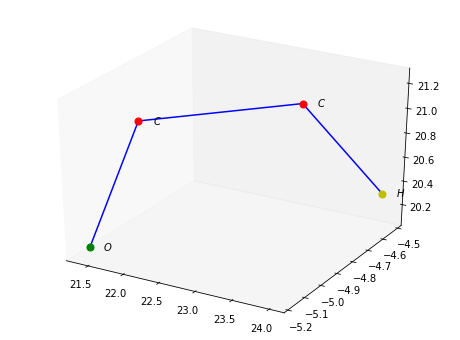

In [17]:
path = paths[1]
coordinate_data = get_3D_coordinates(mol)
xdata = coordinate_data[:, 0]
ydata = coordinate_data[:, 1]
zdata = coordinate_data[:, 2]
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

color_map = {'C': 'r',
             'O': 'g',
             'H': 'y',
             'N': 'b',
             'S': 'm'}


fig = plt.figure(figsize=[8, 6])
ax = plt.axes(projection='3d')
# for path in paths:
for i in range(len(path) - 1):
    ax.plot(xdata[[path[i], path[i + 1]]], ydata[[path[i], path[i + 1]]], zdata[[path[i], path[i + 1]]], color='b')
# for path in paths:
for i in path:
    atom_t = mol[i].ntype
    print(xdata[i], ydata[i], zdata[i])
    ax.scatter3D(xdata[i], ydata[i], zdata[i], s=50, color=color_map[atom_t])
    ax.text(xdata[i] + 0.2, ydata[i], zdata[i], atom_t, style='italic')
ax.grid(False)
plt.show()


The previous plot summarize the coordinate information of a path, originating from 10th atom 'C'.

We can also compute a categorical path which summarize type of the atoms on the path

categorical_path function output a matrix representation of categorical path

In [7]:
path = paths[1]
L = 3
# assign the label to each index
index_map = {'C': 0,
             'O': 1,
             'H': 2,
             'N': 3,
             'S': 4}

cate_path = categorical_path(path,mol, 5, index_map, L)
print(cate_path)

[[0. 0. 1. 2. 2.]
 [0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


Visualization of the categorical path, the paths can summuarize the atom order as showed in the plot 

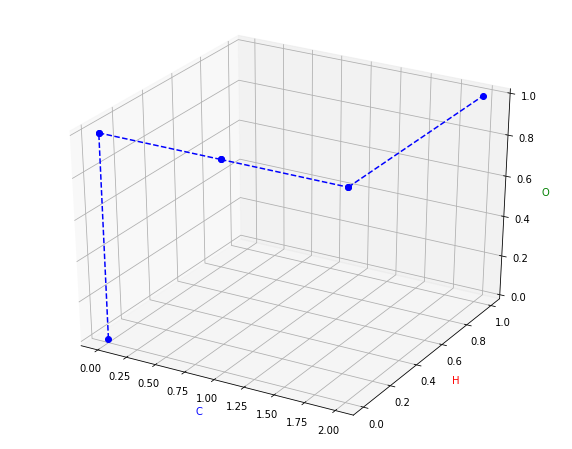

In [8]:
fig = plt.figure(figsize=[10, 8])
ax = plt.axes(projection='3d')
# path_img
for i in range(L + 1):
    ax.plot([cate_path[0, i], cate_path[0, i + 1]], [cate_path[2, i], cate_path[2, i + 1]],
            [cate_path[1, i], cate_path[1, i + 1]], 'go--', color='b')
ax.set_xlabel('C', fontsize=10, color='b')
ax.set_ylabel('H', fontsize='medium', color='r')
ax.set_zlabel('O', fontsize='medium', color='g')
plt.show()


# Compute signature features of the Coordinate paths and Categorical paths

coordinate_path ouput the siganture/logsignature of the all coordinate paths originated from the node up to length L.

output matrix has shape (m,n), m depends on the number of paths at each L. n= sig_dim/logsig_dim depends on the degree of signatures. 

E.g.

In [9]:
# coordinate path
node_index=10
xyz_sig = coordinate_path_sig(node_index,mol, adjacent_matrix, L=3,sig_deg=3,flag=0)
xyz_logsig = coordinate_path_sig(node_index, mol,adjacent_matrix, L=3, sig_deg=3, flag=1)
#print("coordinate_signature=", xyz_sig)
#print("coordingate_logsignature=", xyz_logsig)
print(xyz_sig.shape)
print(xyz_logsig.shape)

(14, 40)
(14, 14)


since the signature/log-sig of a substructure has varied dimension depending on the number of the connected paths, this unfixed dimension casuses trouble for standard learing algirithm. 

Instead, we can compute the expected signature by averaging the over all paths signature and create a vector representation of the substructure to identify the neighbour information around a single atom.

In [10]:
expected_xyz_sig = np.average(xyz_sig, 0)
expected_xyz_logsig = np.average(xyz_logsig, 0)
print("expected coordinate_siganture=",expected_xyz_sig)
print("expected coordinate_siganture=", expected_xyz_logsig)

expected coordinate_siganture= [ 1.          0.96675714  0.475       0.0233      0.98130013  0.22024112
  0.0272103   0.25608235  0.80465391 -0.45366367 -0.0425626  -0.39791074
  2.14169866  0.67063295  0.12377269  0.04156754  0.14083496  0.38814854
 -0.11735998 -0.01494859 -0.10853507  0.95424     0.07344229  0.01637165
 -0.16607651  0.03615302  0.51180679 -0.13881048 -0.17009478 -0.09120361
  0.40051332  0.69738726  0.18416637  0.5495801   0.17593354 -0.76814862
  0.00228059  0.49413696 -0.06099169  0.1453544 ]
expected coordinate_siganture= [ 0.96675714  0.475       0.0233     -0.01792061  0.03488645 -0.02787646
 -0.01407582  0.128142   -0.06525971  0.10565385 -0.12075865 -0.06294785
 -0.05820279 -0.05582674]


Similarly compute the categorical signature. Note that we need to know the number of different atom types in the molecule, and predefine a index_map.

In [13]:
# cateorical path
node_index=10
index_map = {'C': 0,
             'O': 1,
             'H': 2}

cat_sig = categorical_path_sig(node_index,mol,adjacent_matrix, index_map, L=3,cat_dim= 3, sig_deg=3,flag= 0)
cat_logsig = categorical_path_sig(node_index,mol, adjacent_matrix, index_map, L=3, cat_dim=3, sig_deg=3,flag= 1)
#print("categorical_signature=", cat_sig)
#print("categorical_logsignature=", cat_logsig)
print(cat_sig.shape)


(14, 40)


In [14]:
expected_cat_sig=np.average(cat_sig,0)
expected_cat_logsig = np.average(cat_logsig, 0)
print("expected categorical_siganture=",expected_cat_sig)
print("expected categorical_logsiganture=", expected_cat_logsig)

expected categorical_siganture= [ 1.00000000e+00  1.42857143e+00  1.00000000e+00  0.00000000e+00
  1.28571429e+00  0.00000000e+00  0.00000000e+00  1.42857143e+00
  5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.09523810e-01 -7.13714802e-17  0.00000000e+00
  0.00000000e+00 -1.98254112e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.28571429e+00  0.00000000e+00
  0.00000000e+00  7.14285714e-01  1.66666667e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
expected categorical_logsiganture= [ 1.42857143  1.          0.         -0.71428571  0.          0.
  0.21428571  0.         -0.11904762  0.          0.          0.
  0.          0.        ]
